# ESGF Virtual Aggregation

The aim of this project is to create a ready-to-deploy TDS catalog including ALL available data in ESGF, using OPeNDAP endpoints to provide ESGF data analysis while avoiding the download of any data from remote repositories.

In [1]:
import xarray
import dask

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
dask.config.set(scheduler="processes")

In [3]:
ds = xarray.open_dataset(
    "reference://",
    engine="zarr",
    backend_kwargs={
        "consolidated": False,
        "storage_options": {"fo": 'CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_day_tas_gr_v20190410_aims3.llnl.gov.json', "remote_protocol": "https"}
    }).chunk({"variant_label": 1, "time": 400})
v = ds["tas"]

In [4]:
v

<xarray.DataArray 'tas' (variant_label: 5, time: 31411, lat: 128, lon: 256)>
dask.array<xarray-tas, shape=(5, 31411, 128, 256), dtype=float32, chunksize=(1, 400, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height         float64 ...
  * lat            (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon            (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
  * time           (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T1...
  * variant_label  (variant_label) <U8 'r2i1p1f2' 'r3i1p1f2' ... 'r6i1p1f2'
Attributes:
    interval_operation:  900 s
    standard_name:       air_temperature
    cell_methods:        area: time: mean
    online_operation:    average
    history:             none
    cell_measures:       area: areacella
    interval_write:      1 d
    long_name:           Near-Surface Air Temperature
    units:               K
    description:         Near-Surface Air Temperature

## Evolution of temperature

In [5]:
%time tas_mean = v.mean(["lat", "lon"]).compute(num_workers=8)

CPU times: user 910 ms, sys: 111 ms, total: 1.02 s
Wall time: 3min 9s


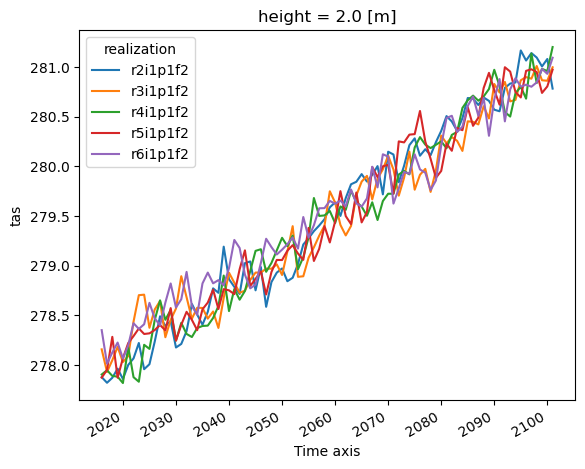

In [6]:
tas_mean.resample({"time": "Y"}).mean().plot.line(x="time")

## Ensemble mean and std by time period

In [7]:
period_boundaries = [
    pd.Timestamp('2015-01-01'),
    pd.Timestamp('2040-04-01'),
    pd.Timestamp('2070-01-01'),
    pd.Timestamp('2100-12-31'),
]

In [8]:
%time ensemble_temporal_mean = v.groupby_bins('time', bins=period_boundaries).mean().compute(num_workers=8)

CPU times: user 5.81 s, sys: 4.27 s, total: 10.1 s
Wall time: 3min 11s


In [9]:
%time ensemble_temporal_std = v.groupby_bins('time', bins=period_boundaries).std().compute(num_workers=8)

CPU times: user 6.16 s, sys: 4.54 s, total: 10.7 s
Wall time: 3min 18s


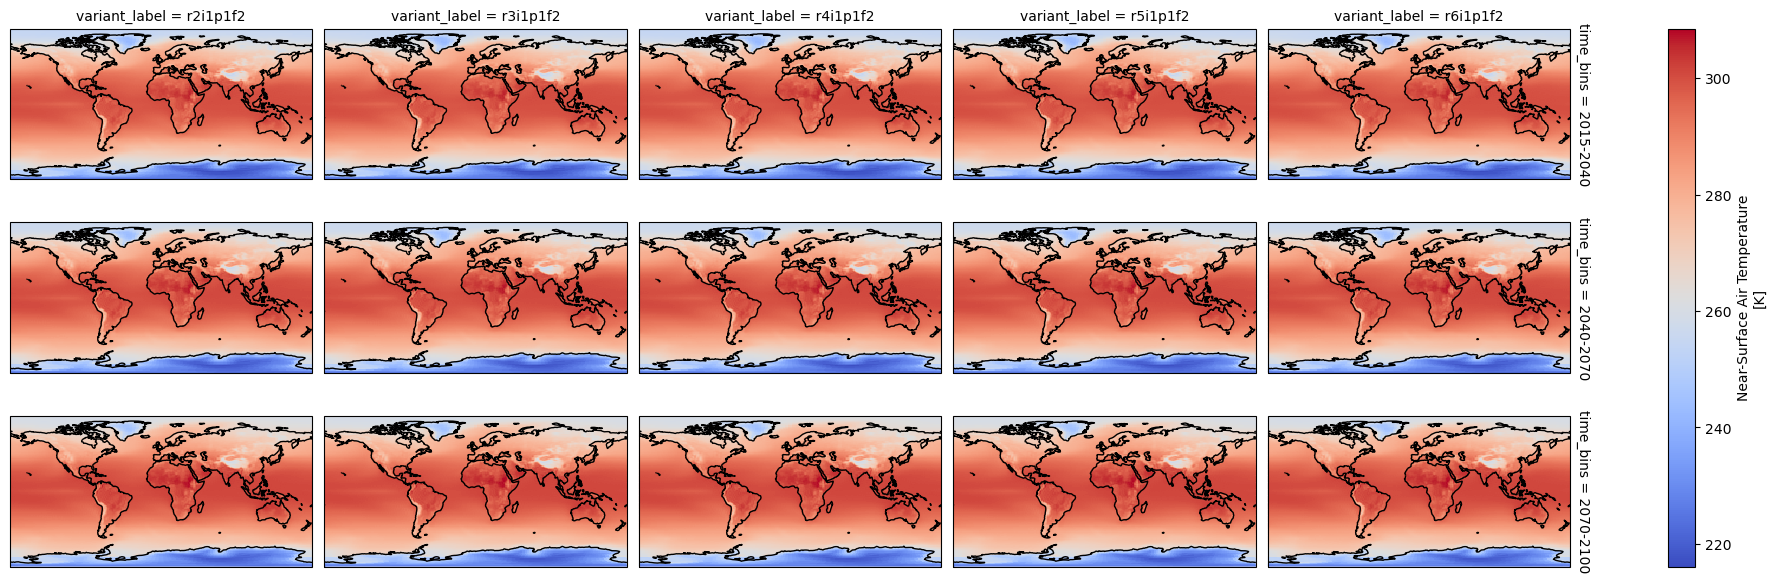

In [10]:
plot = ensemble_temporal_mean.assign_coords({"time_bins": ["2015-2040", "2040-2070", "2070-2100"]}).plot(
    x="lon", y="lat", col="variant_label", row="time_bins",
    figsize=(20,6),
    add_colorbar=True,
    cmap="coolwarm",
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    
#plt.draw()
plt.show()

plot.fig.savefig("mean.png",bbox_inches='tight',dpi=100)

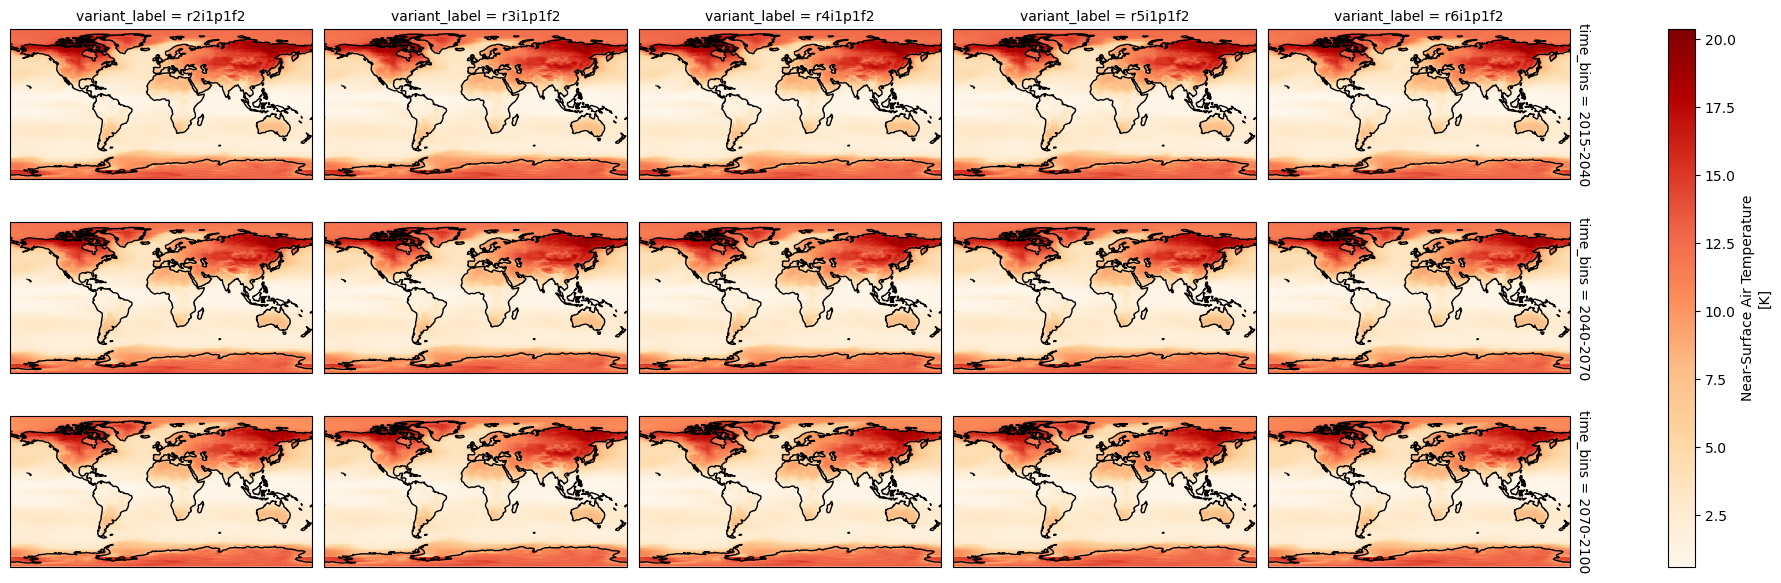

In [11]:
plot = ensemble_temporal_std.assign_coords({"time_bins": ["2015-2040", "2040-2070", "2070-2100"]}).plot(
    x="lon", y="lat", col="variant_label", row="time_bins",
    figsize=(20,6),
    add_colorbar=True,
    cmap="OrRd",
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    
#plt.draw()
plt.show()

plot.fig.savefig("std.png",bbox_inches='tight',dpi=100)

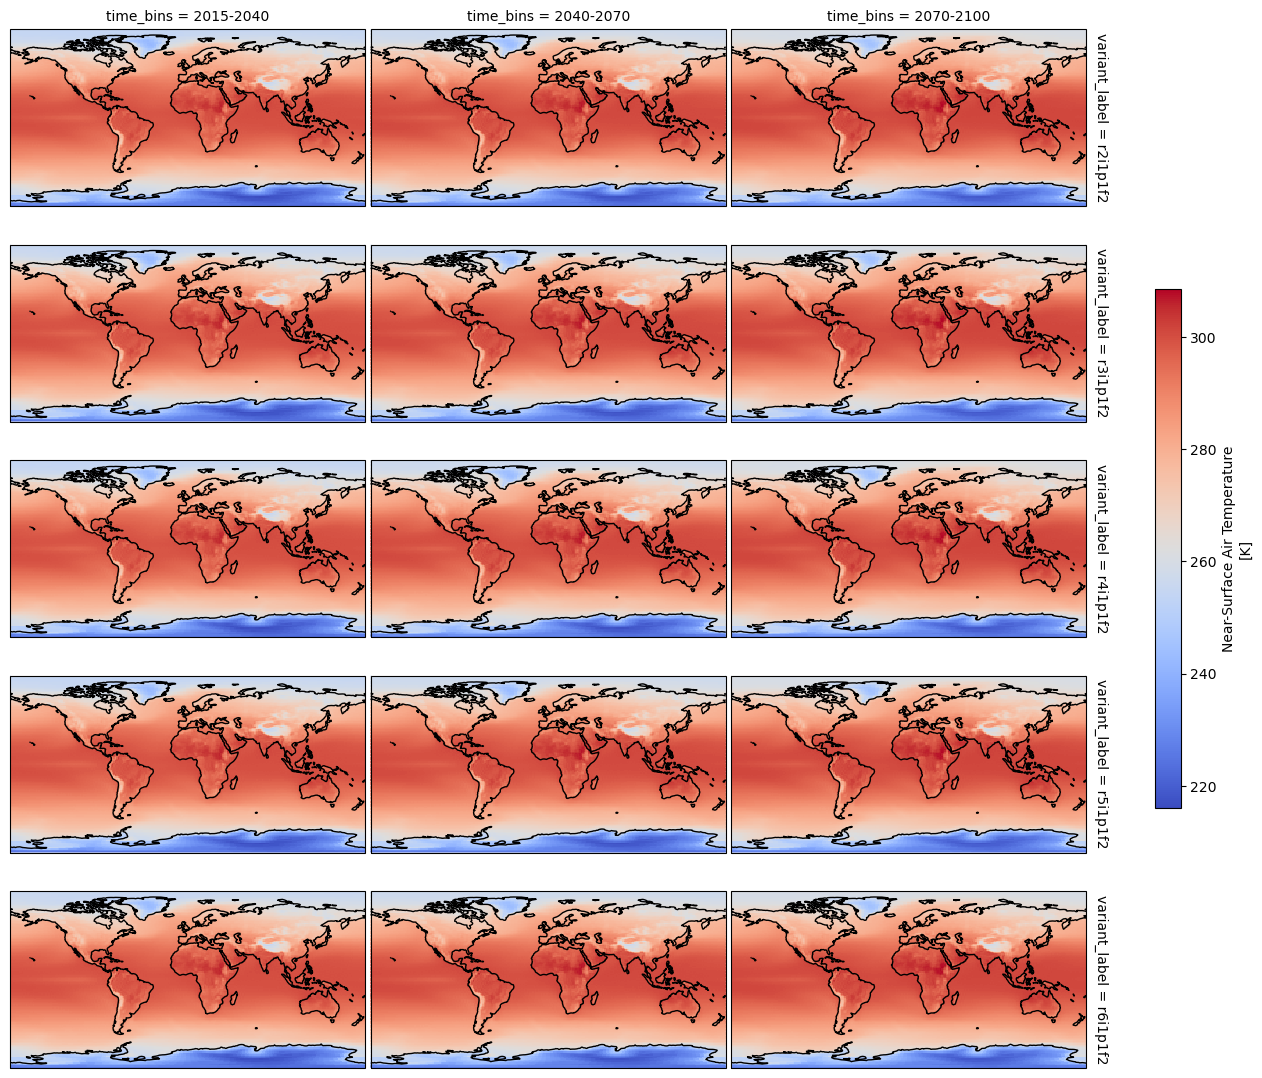

In [12]:
plot = ensemble_temporal_mean.assign_coords({"time_bins": ["2015-2040", "2040-2070", "2070-2100"]}).plot(
    x="lon", y="lat", col="time_bins", row="variant_label",
    figsize=(14,11),
    add_colorbar=True,
    cmap="coolwarm",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    
#plt.draw()
plt.show()

plot.fig.savefig("mean.png",bbox_inches='tight',dpi=100)

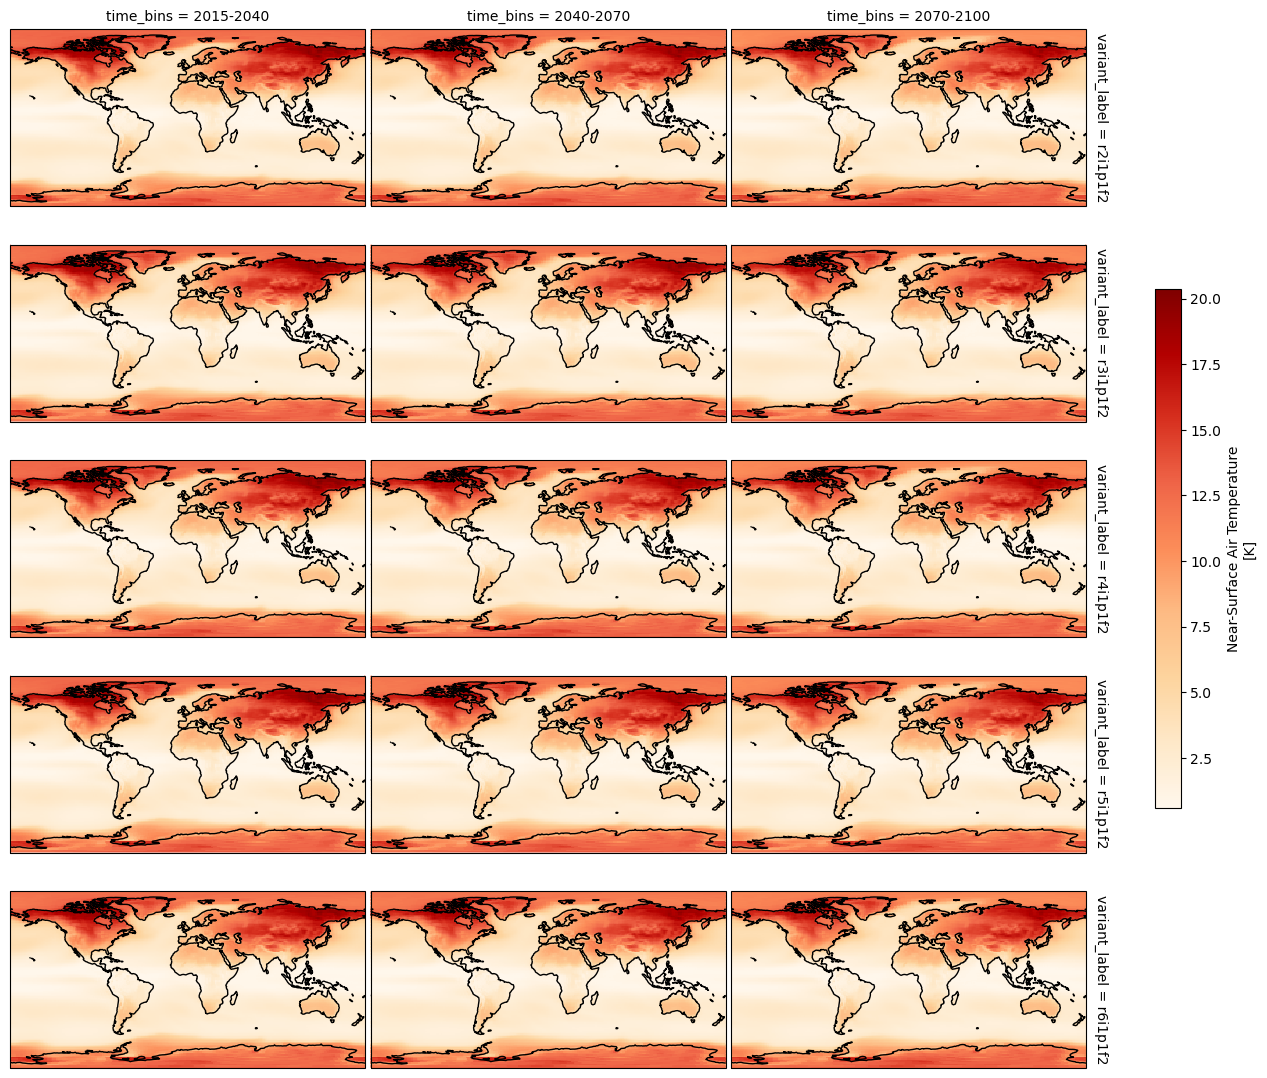

In [13]:
plot = ensemble_temporal_std.assign_coords({"time_bins": ["2015-2040", "2040-2070", "2070-2100"]}).plot(
    x="lon", y="lat", col="time_bins", row="variant_label",
    figsize=(14,11),
    add_colorbar=True,
    cmap="OrRd",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    
#plt.draw()
plt.show()

plot.fig.savefig("std.png",bbox_inches='tight',dpi=100)